In [1]:
%matplotlib inline

import sys
import random
import pickle
import pylab as plt
import networkx as nx
import time
import numpy as np
import itertools
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from collections import defaultdict, Counter
path='/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/'

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % d)
    sys.stdout.flush()
    
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# similarity functions
#def sa(i,j): return len(set(A[i]).intersection(A[j]))/float(min(len(A[i]),len(A[j])))
def sa(i,j): return (len(set(A[i]).intersection(A[j]))-1)/(min(len(A[i]),len(A[j]))-1)# remove the author that tie these two papers together
def sr(i,j): return len(set(R[i]).intersection(R[j]))/min(len(R[i]),len(R[j]))
def sc(i,j): return len(set(C[i]).intersection(C[j]))/min(len(C[i]),len(C[j]))
def sx(i,j): return int(i in R[j])+int(j in R[i])

def disambiguous(papers):
    # iterate over all possible pairs and construct data
    X=np.array([[sa(i,j),sr(i,j),sc(i,j),sx(i,j),i,j] for i,j in itertools.combinations(sorted(papers), 2)])
    # predict linking probability
    y=clt.predict(X[:,:-2])
    # connect nodes
    G = nx.Graph()
    G.add_nodes_from(papers)
    G.add_edges_from(X[:,-2:][y==1].astype(int))
    # export data of component
    data = dict((n,c) for n,c in enumerate(sorted(nx.connected_components(G), key=len, reverse=True)))
    return data

path='/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/'
name='AllEmailsTrainedGradientBoostingClassifier.sav'
clt=pickle.load(open(path+name, 'rb'))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Citation data:

cited_ID citing_ID1, citing_ID2, ....

Reference data:

citing_ID cited_ID1, cited_ID2, ....

Author data:

paper_id, wos_standard_name1, wos_standard_name2, ...

effectivePapers

A & C & R

In [3]:
'''
# effective papers
P=set([])
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/effectivePapers.txt', "r") as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#221
        line=line.strip().split('\t')   
        P.add(int(line[0]))
        
# citation
C={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/PaperCitationList.txt','r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#286
        line=list(map(int,line.strip().split('\t')))
        p=int(line[0])
        if p in P:
            C[p] = line[1:]
            
# reference 
R={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/reference1900_2015.txt','r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#314 
        line=list(map(int,line.strip().split('\t')))
        p=line[0]
        if p in P:
            R[p] = line[1:]

#author name
A={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/authorlist1900_2015.txt','r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#427 
        line=line.strip().split('\t')
        p=int(line[0])
        if p in P:
            A[p] = [i.lower() for i in line[1:]]
            
pickle.dump(C, open(path+'citation.pkl', 'wb'), -1)
pickle.dump(R, open(path+'reference.pkl', 'wb'), -1)
pickle.dump(A, open(path+'author.pkl', 'wb'), -1)
pickle.dump(P, open(path+'effectivePapers.pkl', 'wb'), -1)
'''


221.0

In [2]:
# ~35 minutes
with open(path+'author.pkl', 'rb') as f:
    A = pickle.load(f) 
with open(path+'citation.pkl', 'rb') as f:
    C = pickle.load(f) 
with open(path+'reference.pkl', 'rb') as f:
    R = pickle.load(f) 
with open(path+'effectivePapers.pkl', 'rb') as f:
    P = pickle.load(f)
    
#len(R),len(A),len(C) #22150464

In [4]:
len(R),len(A),len(C)

(22150464, 22150464, 22150464)

# Email data training

In [4]:
E=defaultdict(lambda:{})
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/rawAuthorEmailPaperWOS.txt', "r") as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#153
        line=line.strip().split('\t')
        author,email=line[0].split('+',1)
        author=author.lower()
        if email!='?':
            vs=[int(i) for i in line[1:] if int(i) in P]
            if len(vs)>=2:# with real email and two or more papers relevant to that email
                E[author][email]=vs

153.0

In [5]:
len(E)

867895

In [6]:
Sim=[]
Label=[]
n=0
for e in E:
    n+=1
    if n%1000==0:
        flushPrint(n/1000) #868
    # merge all papers
    papers=sorted([j for i in E[e] for j in E[e][i]])
    # construct dictionary to compare the author-emails of a pair of papers 
    es=dict((j,i) for i in E[e] for j in E[e][i])
    if 2<=len(E[e])<=10 and len(papers)<=200:
        for i,j in itertools.combinations(sorted(papers), 2):
            Sim.append([sa(i,j),sr(i,j),sc(i,j),sx(i,j)])
            Label.append(int(es[i]==es[j]))

867.0

In [7]:
Counter(Label),len(Label)

(Counter({1: 30278129, 0: 31081417}), 61359546)

In [8]:
st=time.time()
forest = GradientBoostingClassifier(n_estimators=3, learning_rate=1.0).fit(Sim, Label)
print(time.time()-st)

239.30703496932983


In [9]:
forest.score(Sim, Label)

0.6703493373304946

In [10]:
#path='/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/'
#name='AllEmailsTrainedGradientBoostingClassifier.sav'
#pickle.dump(forest, open(path+name, 'wb'))

# 'EVANS, JA' testing

In [6]:
E={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/rawAuthorEmailPaperWOS.txt', "r") as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#153
        line=line.strip().split('\t')
        author,email=line[0].split('+',1)
        if author.lower()=='evans, ja' and email!='?':
            vs=[int(i) for i in line[1:] if int(i) in P]
            if len(vs)>=2:# with real email and two or more papers relevant to that email
                E[line[0]]=vs

153.0

In [182]:
papers=set([j for k in E for j in E[k]])
data=disambiguous(papers)

In [183]:
len(papers)

42

In [184]:
# visualization 
X=np.array([[sa(i,j),sr(i,j),sc(i,j),sx(i,j),i,j] for i,j in itertools.combinations(sorted(papers), 2)])
y=clt.predict(X[:,:-2])
G = nx.Graph()
G.add_nodes_from(papers)
G.add_edges_from(X[:,-2:][y==1].astype(int))
E_={j:list(E.keys()).index(k) for k in E for j in E[k]}
data_={j:k for k in data for j in data[k]}

In [185]:
len(G.nodes()),len(G.edges()),len(data),len(E)#(38, 109, 7,10)

(42, 109, 11, 10)

In [204]:
pos = nx.spring_layout(G,k=0.2,iterations=30)
x,y,emailGroup,simGroup=np.array([list(pos[i])+[E_[i],data_[i]] for i in pos]).T

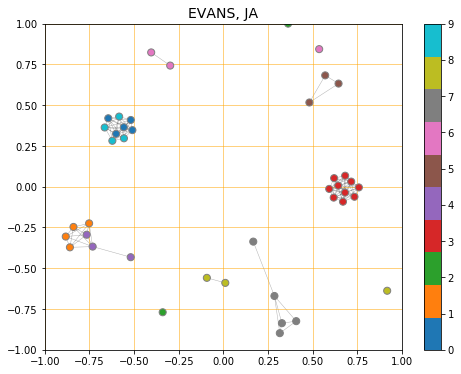

In [242]:
fig=plt.figure(figsize=(8, 6),facecolor='white')
ax = fig.add_subplot(111)
nx.draw_networkx_edges(G,pos,alpha=0.3,width=0.5,arrows=False,zorder=1)
plt.scatter(x,y,s=50,c=emailGroup,cmap='tab10',edgecolor='gray',alpha=1,zorder=2)
plt.colorbar()
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.grid(linestyle='-', linewidth='0.5', color='orange',zorder=0)
plt.title('EVANS, JA',size=14)
#plt.savefig('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/evansJAnewMarked.pdf')

In [243]:
E.keys()

dict_keys(['EVANS, JA+jaevans@ucsd.edu', 'EVANS, JA+je@bgs.ac.uk', 'EVANS, JA+j.a.evans@bristol.ac.uk', 'EVANS, JA+evans@ices.utexas.edu', 'EVANS, JA+je@nigl.nerc.ac.uk', 'EVANS, JA+evans@kccr.de', 'EVANS, JA+jevans@ms.umanitoba.ca', 'EVANS, JA+jevans@uchicago.edu', 'EVANS, JA+jaredaevans@gmail.com', 'EVANS, JA+jevans@msm.edu'])

In [121]:
#list(sorted(zip(simGroup,emailGroup)))
#1,4 and 0,9
list(E.keys())[1],list(E.keys())[4] #https://www.bgs.ac.uk/staff/profiles/0394.html  school of Archaeology

('EVANS, JA+je@bgs.ac.uk', 'EVANS, JA+je@nigl.nerc.ac.uk')

In [89]:
list(E.keys())[0],list(E.keys())[9] # department of psychology

('EVANS, JA+jaevans@ucsd.edu', 'EVANS, JA+jevans@msm.edu')

# Ground truth testing

In [35]:
'''
O={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/orcid/ORCIDmatchedScholars_byTitleDoi.txt','r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)
        line=line.strip().split('\t')
        O[int(line[0])]=list(map(int,line[1:]))
        
len(O)#155419

AU={}
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/authorlist1900_2015.txt','r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#427
        line=line.strip().split('\t')
        p=int(line[0])
        AU[p]=line[1:]
        
def matchAuthor(name):
    K=defaultdict(lambda:0)
    m=0
    for p in O[name]:
        if p in AU:
            m+=1
            for n in AU[p]:
                K[n]+=1
    vs=[k for k,v in K.items() if v==m]
    if len(vs)==1:
        return vs[0]
    
M=[]
n=0
for name in O:
    n+=1
    if n%1000==0:
        flushPrint(n/1000)#150
    au=matchAuthor(name)
    if au:
        M.append([au.lower()]+O[name])

with open(path+'ORCIDwithAuthorName.txt', 'w') as f:
    for v in M:
        f.write('\t'.join(map(str,v))+'\n')
'''

1.0

In [2]:
N=[]
with open(path+'ORCIDwithAuthorName.txt', 'r') as f:
    for line in f:
        line=line.strip().split('\t')
        N.append([line[0]]+list(map(int,line[1:])))

In [3]:
names=set([i[0] for i in N])

In [4]:
len(names),len(N)

(46642, 50189)

In [ ]:
#nordquist, n

In [7]:
n=0
with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/PaperListEffective.txt', "r") as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#84
        line=line.strip().split('\t')
        author=line[0].lower()   # first break down               # second break down
        if author =='yeh, tf':# #'nordquist, n' #n==7801155 #     #'yeh, tf' #n==8207337 #
            print(len(line)-1)
            break

82.064


In [9]:
n

8207337

In [ ]:
# export predictions 
with open(path+'ORCIDprediction3.txt', 'w') as f1:
    n=0
    with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/PaperListEffective.txt', "r") as f:
        for line in f:
            n+=1
            #if n>7801155:
            if n>8207337:
                if n%10000==0:
                    flushPrint(n/10000)#840
                line=line.strip().split('\t')
                author=line[0].lower()
                if author in names:
                    papers=list(map(int,line[1:]))
                    if len(papers)<=100:
                            dic=disambiguous(papers) 
                            s='\t'.join(['__'.join((str(k),'_'.join(map(str,sorted(v))))) for k,v in dic.items()])
                            f1.write(author+'\t'+s+'\n')

826.0

In [8]:
n=0
PP=[]
with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/PaperListEffective.txt', "r") as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)#84
        if n>7801155:
            line=line.strip().split('\t')
            author=line[0].lower()
            if author in names:
                papers=list(map(int,line[1:]))
                PP.append([author,len(papers)])

84.0

In [ ]:
# export predictions 
with open(path+'ORCIDprediction.txt', 'w') as f1:
    n=0
    with open('/Users/lingfeiw/Documents/research/teamscience/team/BillNameDis/PaperListEffective.txt', "r") as f:
        for line in f:
            n+=1
            if n%100000==0:
                flushPrint(n/100000)#84
            line=line.strip().split('\t')
            author=line[0].lower()
            if author in names:
                papers=list(map(int,line[1:]))
                if len(papers)==1:
                    dic={0:set(papers)}
                else:
                    dic=disambiguous(papers) 
                s='\t'.join(['__'.join((str(k),'_'.join(map(str,sorted(v))))) for k,v in dic.items()])
                f1.write(author+'\t'+s+'\n')

79.0

In [5]:
# import predictions
U={}
with open(path+'ORCIDprediction.txt', 'r') as f:
    for line in f:
        line=line.strip().split('\t')
        author=line[0]
        papers=[i.split('__') for i in line[1:]] 
        dic={int(k):list(map(int,v.split('_'))) \
             for k,v in papers}
        U[author]=dic
with open(path+'ORCIDprediction2.txt', 'r') as f:
    for line in f:
        line=line.strip().split('\t')
        author=line[0]
        papers=[i.split('__') for i in line[1:]] 
        dic={int(k):list(map(int,v.split('_'))) \
             for k,v in papers}
        U[author]=dic


In [6]:
len(U)

40346

In [7]:
len(N)

50189

In [19]:

i=N[0]
name=i[0]

data=[]
num=0
l2=len(set(U[name][num]).intersection(papers))
l2

In [43]:
dd=[]
n=0
for i in N:
    n+=1
    if n%1000==0:
        flushPrint(n/1000)#45
    name=i[0]
    if name in U:
        papers=set(i[1:])
        if len(papers)>=3:
            l0=len(papers)
            data=[]
            for num in U[name]:
                l2=len(set(U[name][num]).intersection(papers))
                l1=len(U[name][num])
                precision=l2/float(l1)
                recall=l2/float(l0)
                data.append([recall,precision,l1])
            dd.append(sorted(data)[-1])

50.0

In [45]:
len(dd)

37620

In [44]:
dd[:3]

[[0.1, 1.0, 1],
 [0.6666666666666666, 0.6956521739130435, 23],
 [0.6666666666666666, 1.0, 6]]

In [41]:
np.mean(dd,axis=0)

array([ 0.48170425,  0.69676335, 10.9800363 ])

In [46]:
np.mean(dd,axis=0)

array([ 0.50537871,  0.72492725, 11.29819245])

In [42]:
np.median(dd,axis=0)

array([0.5, 1. , 7. ])

In [47]:
np.median(dd,axis=0)

array([0.58333333, 1.        , 7.        ])